# 状態空間モデルに対するハミルトニアンモンテカルロ法

「Juliaで作って学ぶベイズ統計学」P.217 参照

In [1]:
using Distributions
using Plots
using ForwardDiff
using LinearAlgebra

eye(n) = Diagonal{Float64}(I, n)

eye (generic function with 1 method)

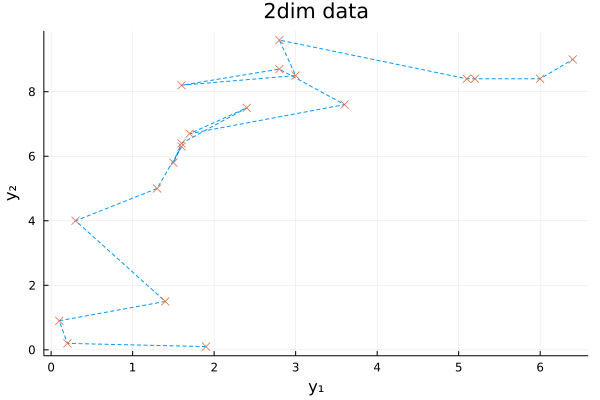

In [2]:
N = 20
D = 2
Y_obs = [
    1.9 0.2 0.1 1.4 0.3 1.3 1.6 1.5 1.6 2.4 #=
=#  1.7 3.6 2.8 1.6 3.0 2.8 5.1 5.2 6.0 6.4;
    0.1 0.2 0.9 1.5 4.0 5.0 6.3 5.8 6.4 7.5 #=
=#  6.7 7.6 8.7 8.2 8.5 9.6 8.4 8.4 8.4 9.0
]

plot(Y_obs[1, :], Y_obs[2, :], xlab="y₁", ylab="y₂", title="2dim data", label=:none, linestyle=:dash)
scatter!(Y_obs[1, :], Y_obs[2, :], label=:none, markershape=:xcross)

In [3]:
σ₁ = 100.0
σ_x = 1.0
σ_y = 1.0

@views transition(X, σ₁, σ_x, D, N) =
    logpdf(MvNormal(zeros(D), σ₁ * eye(D)), X[:, 1]) +
    sum([logpdf(MvNormal(X[:, n-1], σ_x * eye(D)), X[:, n]) for n in 2:N])

@views observation(X, Y, σ_y, D, N) =
    sum([logpdf(MvNormal(X[:, n], σ_y * eye(D)), Y[:, n]) for n in 1:N])

log_joint_tmp(X, Y, σ₁, σ_x, σ_y, D, N) =
    transition(X, σ₁, σ_x, D, N) +
    observation(X, Y, σ_y, D, N)

log_joint(X_vec, Y, σ₁, σ_x, σ_y, D, N) =
    log_joint_tmp(reshape(X_vec, D, N), Y, σ₁, σ_x, σ_y, D, N)
params = (Y_obs, σ₁, σ_x, σ_y, D, N)

ulp(X_vec) = log_joint(X_vec, params...)

ulp (generic function with 1 method)

In [4]:
function hmc(log_p_tilde, μ₀, maxiter, L, ϵ)
    function leapflog(grad, p_in, μ_in, L, ϵ)
        μ = μ_in
        p = p_in + 0.5 * ϵ * grad(μ)
        for l in 1:L-1
            μ += ϵ * p
            p += ϵ * grad(μ)
        end
        μ += ϵ * p
        p += 0.5 * ϵ * grad(μ)
        p, μ
    end
    grad(μ) = ForwardDiff.gradient(log_p_tilde, μ)
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    μ_samples[:, 1] = μ₀
    num_accepted = 1
    for i in 2:maxiter
        p_in = randn(size(μ₀))
        p_out, μ_out = leapflog(grad, p_in, μ_samples[:, i-1], L, ϵ)
        μ_in = μ_samples[:, i-1]
        log_r = (log_p_tilde(μ_out) +
                logpdf(MvNormal(zeros(D), eye(D)), vec(p_out))) -
                (log_p_tilde(μ_in) +
                logpdf(MvNormal(zeros(D), eye(D)), vec(p_in)))
        is_accepted = min(1, exp(log_r)) > rand()
        new_sample = is_accepted ? μ_out : μ_in
        μ_samples[:, i] = new_sample
        num_accepted += is_accepted
    end
    μ_samples, num_accepted
end

function inference_wrapper_hmc(log_joint, params, w_init, maxiter, L, ϵ)
    ulp(w) = log_joint(w, params...)
    hmc(ulp, w_init, maxiter, L, ϵ)
end


inference_wrapper_hmc (generic function with 1 method)

In [5]:
X_init = randn(D * N)
maxiter = 1000
L = 100
ϵ = 0.01

samples, num_accepted =
    inference_wrapper_hmc(log_joint, params, X_init, maxiter, L, ϵ)

println("acceptance rate = $(num_accepted / maxiter)")

acceptance rate = 1.0


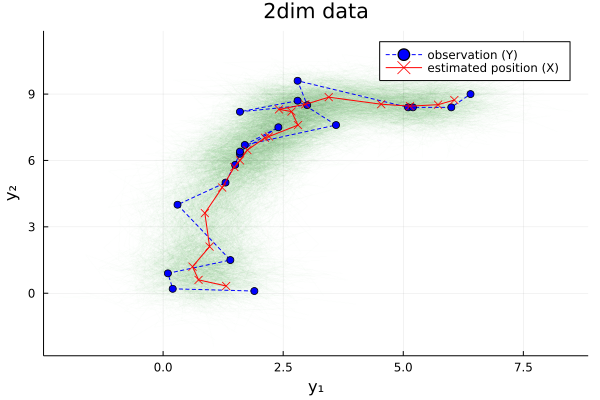

In [6]:
p = plot(xlab="y₁", ylab="y₂", title="2dim data")
for i in 1:maxiter
    X = reshape(samples[:, i], 2, N)
    p = plot!(X[1, :], X[2, :], alpha=10.0/maxiter, label=:none, color="green")
end
p = plot!(Y_obs[1, :], Y_obs[2, :], label="observation (Y)", linecolor=:blue,
          linestyle=:dash, marker=:circle, markercolor=:blue)

mean_trace = reshape(mean(samples, dims=2), 2, N)
p = plot!(mean_trace[1, :], mean_trace[2, :], linecolor=:red,
          label="estimated position (X)", marker=:xcross, markercolor=:red)

p

## 状態空間モデルの回帰への適用

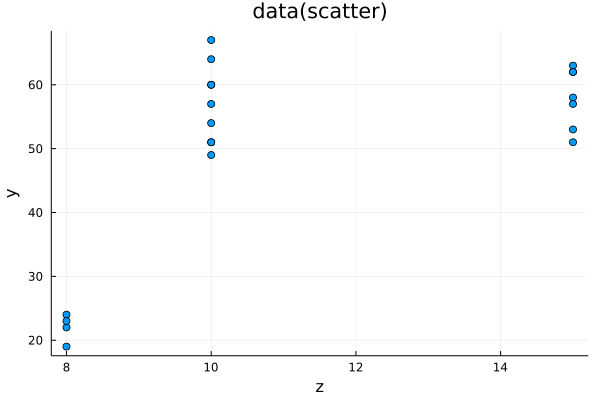

In [7]:
N = 20
Z_obs = [
    10, 10, 10, 10, 10, 10, 10, 10, 10, 15,
    15, 15, 15, 15, 15, 15, 8, 8, 8, 8
]

Y_obs = [
    67, 64, 60, 60, 57, 54, 51, 51, 49, 63,
    62, 62, 58, 57, 53, 51, 24, 22, 23, 19
]

scatter(Z_obs, Y_obs, xlab="z", ylab="y", title="data(scatter)", label=:none)

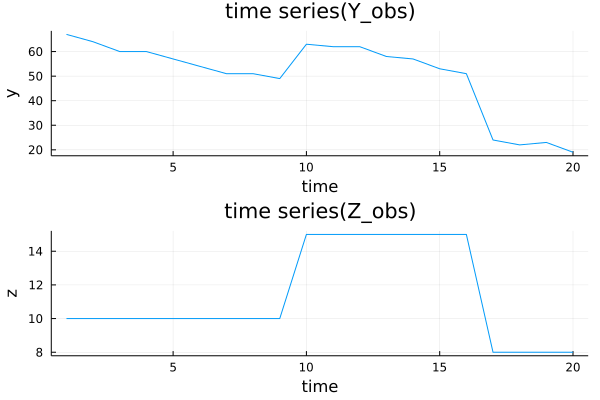

In [8]:
plot(
    plot(Y_obs, xlab="time", ylab="y", title="time series(Y_obs)", label=:none), 
    plot(Z_obs, xlab="time", ylab="z", title="time series(Z_obs)", label=:none),
    layout=(2,1)
)

In [9]:
σ₁ = 10.0
σ_x = 1.0
σ_y = 0.5
σ_w = 100.0

prior(w, σ_w) = logpdf(MvNormal(zeros(2), σ_w * eye(2)), w)

@views transition(X, σ₀, σ_x) =
    logpdf(Normal(0, σ₀), X[1]) +
    sum(logpdf.(Normal.(X[1:N-1], σ_x), X[2:N]))

@views observation(X, Y, Z, w) =
    sum(logpdf.(Normal.(w[1] * Z .+ w[2] + X, σ_y), Y))

log_joint(X, w, Y, Z, σ_w, σ₀, σ_x) =
    transition(X, σ₀, σ_x) +
    observation(X, Y, Z, w) +
    prior(w, σ_w)
@views log_joint(X_vec, Y, Z, σ_w, σ₀, σ_x) =
    transition(X_vec[1:N], σ₀, σ_x) +
    observation(X_vec[1:N], Y, Z, X_vec[N+1:N+2]) +
    prior(X_vec[N+1:N+2], σ_w)

params = (Y_obs, Z_obs, σ_w, σ₁, σ_x)

x_init = randn(N+2)
maxiter = 1000
L = 100
ϵ = 1e-2
samples, num_accepted =
    inference_wrapper_hmc(log_joint, params, x_init, maxiter, L, ϵ)

println("acceptance rate = $(num_accepted / maxiter)")

acceptance rate = 0.961


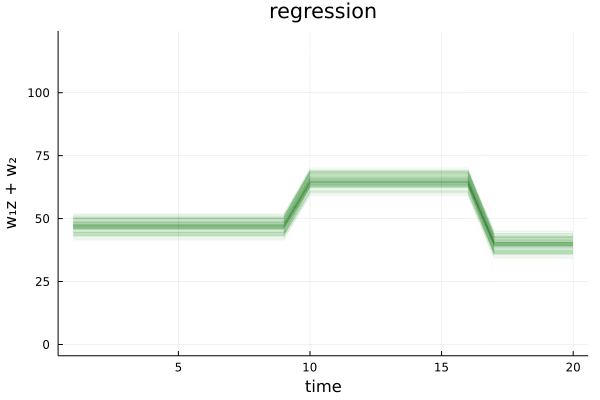

In [12]:
p = plot(xlab="time", ylab="w₁z + w₂", title="regression")
for i in 1:maxiter
    w₁, w₂ = samples[[N+1, N+2], i]
    p = plot!(w₁ * Z_obs .+ w₂, alpha=10/maxiter, color="green", label=:none)
end
p

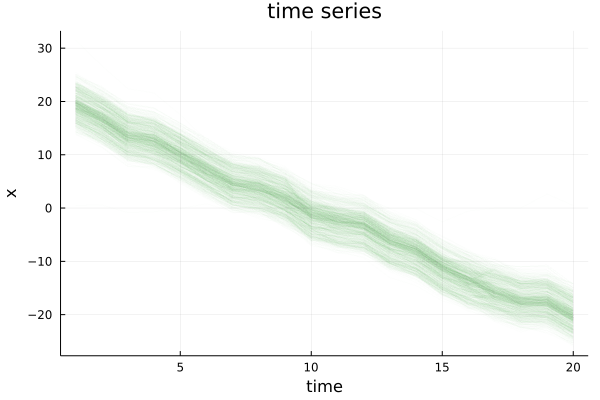

In [13]:
p1 = plot(xlab="time", ylab="x", title="time series")
for i in 1:maxiter
    X = samples[1:N, i]
    p1 = plot!(X, alpha=10/maxiter, color="green", label=:none)
end
p1

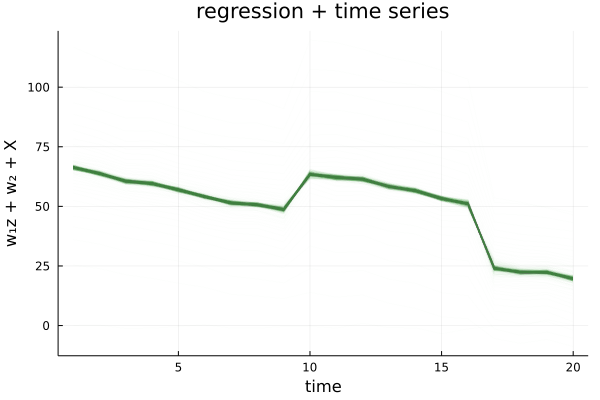

In [14]:
p2 = plot(xlab="time", ylab="w₁z + w₂ + X", title="regression + time series")
for i in 1:maxiter
    w₁, w₂ = samples[[N+1, N+2], i]
    X = samples[1:N, i]
    p2 = plot!(w₁ * Z_obs .+ w₂ + X, alpha=10/maxiter, color="green", label=:none)
end
p2